Itaú Unibanco Holding S.A. (ITUB4.SA)
Nvidia (NVDA)

In [30]:
import yfinance as yf
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

Corp informations

In [16]:
df = yf.Ticker("NVDA").history(period="max")
df = df[['Close']].reset_index()
df['Date'] = pd.to_datetime(df['Date']).dt.date
df

,Date,Close
0,1999-01-22,0.037618
1,1999-01-25,0.041559
2,1999-01-26,0.038334
3,1999-01-27,0.038215
4,1999-01-28,0.038095
...,...,...
6488,2024-11-04,136.050003
6489,2024-11-05,139.910004
6490,2024-11-06,145.610001
6491,2024-11-07,148.880005


Data Visualization

In [17]:
# preparando o dataset para o treino
numero_dias_predicao = 14

df.set_index('Date', inplace=True)

for i in range(numero_dias_predicao, 0, -1):
    df[f'close(t-{i})'] = df['Close'].shift(i)
df.dropna(inplace=True)
df


,Close,close(t-14),close(t-13),close(t-12),close(t-11),close(t-10),close(t-9),close(t-8),close(t-7),close(t-6),close(t-5),close(t-4),close(t-3),close(t-2),close(t-1)
Date,,,,,,,,,,,,,,,
1999-02-11,0.037737,0.037618,0.041559,0.038334,0.038215,0.038095,0.036303,0.037021,0.034155,0.034871,0.036781,0.037856,0.036543,0.035109,0.034752
1999-02-12,0.039887,0.041559,0.038334,0.038215,0.038095,0.036303,0.037021,0.034155,0.034871,0.036781,0.037856,0.036543,0.035109,0.034752,0.037737
1999-02-16,0.040125,0.038334,0.038215,0.038095,0.036303,0.037021,0.034155,0.034871,0.036781,0.037856,0.036543,0.035109,0.034752,0.037737,0.039887
1999-02-17,0.037975,0.038215,0.038095,0.036303,0.037021,0.034155,0.034871,0.036781,0.037856,0.036543,0.035109,0.034752,0.037737,0.039887,0.040125
1999-02-18,0.038573,0.038095,0.036303,0.037021,0.034155,0.034871,0.036781,0.037856,0.036543,0.035109,0.034752,0.037737,0.039887,0.040125,0.037975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-04,136.050003,131.600006,135.720001,136.929993,138.000000,143.710007,143.589996,139.559998,140.410004,141.539993,140.520004,141.250000,139.339996,132.759995,135.399994
2024-11-05,139.910004,135.720001,136.929993,138.000000,143.710007,143.589996,139.559998,140.410004,141.539993,140.520004,141.250000,139.339996,132.759995,135.399994,136.050003
2024-11-06,145.610001,136.929993,138.000000,143.710007,143.589996,139.559998,140.410004,141.539993,140.520004,141.250000,139.339996,132.759995,135.399994,136.050003,139.910004


In [18]:
from sklearn.preprocessing import MinMaxScaler

shifted_df_as_np = df.to_numpy()
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

x = shifted_df_as_np[:, 1:]
y = shifted_df_as_np[:, 0]

x.shape, y.shape


((6479, 14), (6479,))

In [19]:
split_index = int(len(x) * 0.95)
split_index 

x_train = x[:split_index]
x_test = x[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((6155, 14), (324, 14), (6155,), (324,))

In [20]:
x_train = x_train.reshape((-1, numero_dias_predicao, 1))
x_test = x_test.reshape((-1, numero_dias_predicao, 1))

y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((6155, 14, 1), (324, 14, 1), (6155, 1), (324, 1))

In [21]:
x_train = torch.tensor(x_train).float()
x_test = torch.tensor(x_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()
x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([6155, 14, 1]),
 torch.Size([324, 14, 1]),
 torch.Size([6155, 1]),
 torch.Size([324, 1]))

In [22]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.X = x
        self.y = y 
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(x_train, y_train)
test_dataset = TimeSeriesDataset(x_test, y_test)

In [23]:
from torch.utils.data import DataLoader

batch_size = 6

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [24]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break 

torch.Size([6, 14, 1]) torch.Size([6, 1])


In [25]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])

        return out 
    
model = LSTM(1, 4, 1)
model.to(device)
model 

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [ ]:
def train_one_epoch(epoch, optimizer, loss_function):
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item() 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:
            avg_loss_across_batches = running_loss / 100
            print(f'Batch {batch_index+1}, Loss: {avg_loss_across_batches:.3f}')

            running_loss = 0.0
    print()

def validade_one_epoch(loss_function):
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss 

    avg_loss_across_batches = running_loss / len(test_loader)

    print(f'Val Loss: {avg_loss_across_batches:.3f}')



In [ ]:
learning_rate = 0.001
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch(epoch, optimizer, loss_function)
    validade_one_epoch(loss_function) 

Epoch: 1
Batch 100, Loss: 1.864
Batch 200, Loss: 0.563
Batch 300, Loss: 0.019
Batch 400, Loss: 0.006
Batch 500, Loss: 0.009
Batch 600, Loss: 0.005
Batch 700, Loss: 0.006
Batch 800, Loss: 0.006
Batch 900, Loss: 0.005
Batch 1000, Loss: 0.006

Val Loss: 0.348
Epoch: 2
Batch 100, Loss: 0.004
Batch 200, Loss: 0.004
Batch 300, Loss: 0.004
Batch 400, Loss: 0.003
Batch 500, Loss: 0.003
Batch 600, Loss: 0.002
Batch 700, Loss: 0.002
Batch 800, Loss: 0.001
Batch 900, Loss: 0.000
Batch 1000, Loss: 0.000

Val Loss: 0.097
Epoch: 3
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000
Batch 600, Loss: 0.000
Batch 700, Loss: 0.000
Batch 800, Loss: 0.000
Batch 900, Loss: 0.000
Batch 1000, Loss: 0.000

Val Loss: 0.077
Epoch: 4
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000
Batch 600, Loss: 0.000
Batch 700, Loss: 0.000
Batch 800, Loss: 0.000
Batch 900, Loss: 0.000
Batch 1000, L

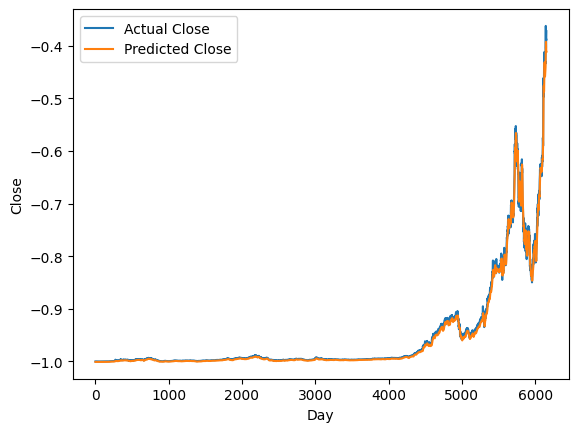

In [45]:
with torch.no_grad():
    predicted = model(x_train.to(device)).to('cpu').numpy()

torch.save(model, '../model/torch_model.pth')

plt.plot(y_train, label= 'Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show() 

In [36]:
train_predictions = predicted.flatten()

dummies = np.zeros((x_train.shape[0], numero_dias_predicao+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dummies[:, 0]
train_predictions


array([-2.71518339e-02, -2.69477762e-02, -2.64065796e-02, ...,
        4.39889305e+01,  4.38038103e+01,  4.38036106e+01])

In [37]:
dummies = np.zeros((x_train.shape[0], numero_dias_predicao+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dummies[:, 0]
new_y_train


C:\Users\kassi\AppData\Local\Temp\ipykernel_31808\901145848.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dummies[:, 0] = y_train.flatten()


array([3.77385217e-02, 3.98855638e-02, 4.01251098e-02, ...,
       4.54345131e+01, 4.58823400e+01, 4.67320142e+01])

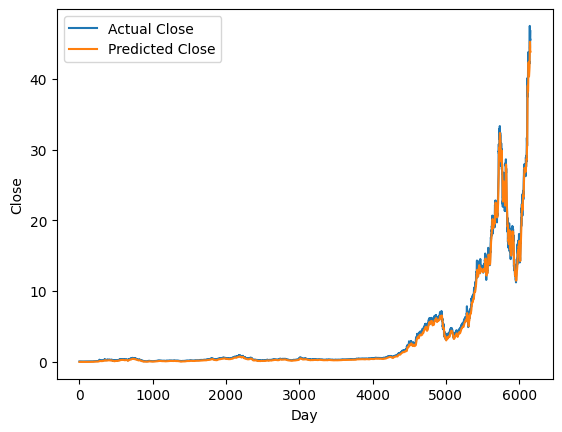

In [38]:
plt.plot(new_y_train, label= 'Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show() 

In [40]:
test_predictions = model(x_test.to(device)).detach().cpu().numpy().flatten()
dummies = np.zeros((x_test.shape[0], numero_dias_predicao+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dummies[:, 0]
test_predictions


array([ 44.05550214,  44.34694537,  44.57309899,  44.24867827,
        43.87711133,  43.55556073,  43.46752313,  43.29859882,
        42.70583776,  42.08936607,  41.24163488,  41.15357067,
        41.33096337,  41.53929299,  41.73010471,  41.87186715,
        42.77277312,  43.38864595,  44.19500665,  44.86075827,
        45.08447208,  45.27016017,  45.76096335,  46.31820507,
        46.80529972,  46.98030583,  46.99783262,  46.58388378,
        45.92897383,  45.15789293,  44.41932819,  43.76629025,
        43.43571674,  43.31514524,  42.96499106,  42.69365196,
        42.40710612,  41.91412041,  41.2149743 ,  40.72652665,
        40.52825796,  40.41530314,  40.52105383,  40.82776146,
        41.24981493,  41.92616869,  42.26760162,  42.57845694,
        42.90802347,  43.39292672,  43.69313999,  43.98920556,
        44.41200429,  44.79988697,  44.76583595,  44.7410518 ,
        44.20149214,  43.24401782,  42.30043273,  41.37080785,
        40.99550134,  41.03625522,  40.85288718,  40.40

In [41]:
dummies = np.zeros((x_test.shape[0], numero_dias_predicao+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)
new_y_test = dummies[:, 0]
new_y_test

C:\Users\kassi\AppData\Local\Temp\ipykernel_31808\39126356.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dummies[:, 0] = y_test.flatten()


array([ 46.7110184 ,  46.48910119,  44.25196537,  44.49787045,
        44.66280454,  45.39952389,  44.64681706,  42.53762543,
        42.3716888 ,  40.83927963,  43.73616068,  43.92308864,
        43.46926427,  43.32731995,  43.28233631,  46.94892974,
        45.65042839,  47.09787413,  47.14485177,  46.00029422,
        46.81697759,  48.76522756,  49.24504046,  49.33601028,
        48.49033297,  48.52931687,  47.04676433,  46.22701566,
        45.55821648,  45.16433628,  44.85642648,  45.47124575,
        45.56721942,  43.88672201,  43.95270141,  43.50683529,
        42.2262267 ,  41.004593  ,  41.59741174,  42.2092278 ,
        41.89832368,  42.45515506,  43.07596519,  43.4858484 ,
        44.76845543,  43.50383431,  44.02768375,  44.67448463,
        45.74815651,  45.25930297,  45.7841483 ,  46.791843  ,
        46.93079744,  45.44724678,  46.08105894,  43.92471002,
        42.18323928,  42.08826815,  41.37448089,  42.96200117,
        43.64979103,  41.76636044,  40.31380438,  40.48

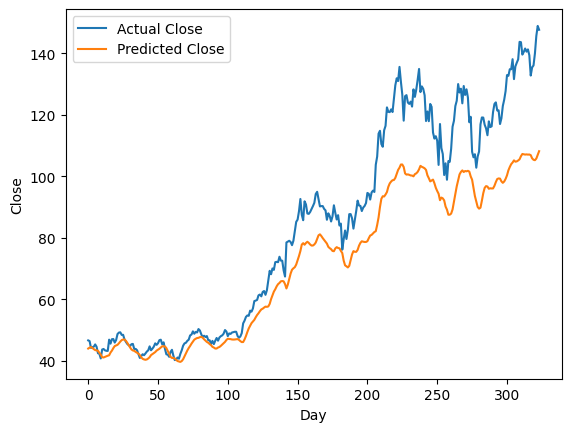

In [42]:
plt.plot(new_y_test, label= 'Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show() 

Qual o período permitido ?
Qual o intervalo ?
Lista de papéis

https://aroussi.com/post/python-yahoo-finance

Available paramaters for the history() method are:

    period: data period to download (Either Use period parameter or use start and end) Valid periods are: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max
    interval: data interval (intraday data cannot extend last 60 days) Valid intervals are: 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo
    start: If not using period - Download start date string (YYYY-MM-DD) or datetime.
    end: If not using period - Download end date string (YYYY-MM-DD) or datetime.
    prepost: Include Pre and Post market data in results? (Default is False)
    auto_adjust: Adjust all OHLC automatically? (Default is True)
    actions: Download stock dividends and stock splits events? (Default is True)



link do yt de apoio
https://www.youtube.com/watch?v=q_HS4s1L8UI&t=181s